<a href="https://colab.research.google.com/github/Laeti-dev/Project4-Credit-Scoring-Model/blob/EDA/ikusawa_laetitia_1_notebook_0824.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on [this kaggle notebook](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Read-in-Data)

# Imports

In [1]:
# check if the notebook is on colab
import os

if os.path.exists("/content"):
    path = "/content"
    # install dependencies
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install scikit-learn
else:
    path = "./data"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploration

There are 9 data files and 1 file explaining the variables that we'll load to understand our data.

## Columns description

In [3]:
columns_description = pd.read_csv(
    f"{path}/HomeCredit_columns_description.csv", encoding="latin1", index_col=0
)


In [4]:
columns_description['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [5]:
application_description = columns_description[columns_description['Table'] == 'application_{train|test}.csv']

We will work on the application_train file to start with because it contains our target.

## Application

In [6]:
application_train = pd.read_csv(f"{path}/application_train.csv")
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
application_train.shape

(307511, 122)

The training dataset has 307,511 rows where each row is a loan application and 122 columns including our target (TARGET).

In [8]:
application_test = pd.read_csv('./data/application_test.csv')
application_test.shape

(48744, 121)

The testing dataset contains only 48,744 rows and does not contains a target to évaluet the prediction.

Lest's explore our train data

# EDA

## Target column distribution

In [9]:
application_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

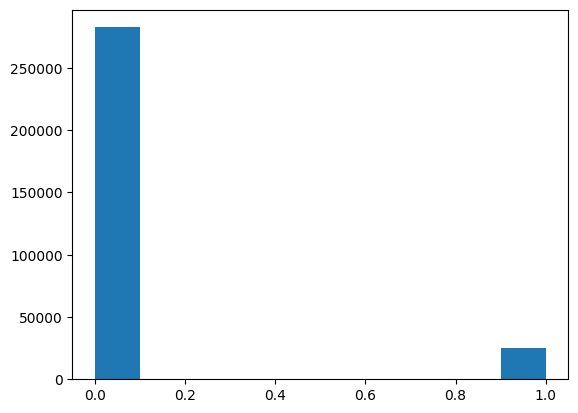

In [10]:
fig, ax = plt.subplots()

ax.hist(application_train['TARGET'])
plt.show()

We observe that this is an imbalanced class. A lot more loans have been reapaid con time than loans that were not repaid.

## Missing values

In [11]:
def missing_values_table(df):
    """
    Takes the dataframe and display missing values count and ratio
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Ratio of missing values
    mis_val_ratio = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_ratio], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by ratio of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [12]:
missing_values = missing_values_table(application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [13]:
# get a list of columns with missing values
missing_columns = list(missing_values[missing_values['% of Total Values'] > 0].index)

In [14]:
application_train[missing_columns].head()

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_AVG,FONDKAPREMONT_MODE,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_AVG,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE
0,0.0144,0.0143,0.0144,0.0000,0.0,0.0000,reg oper account,0.022,0.0205,0.0202,...,0.0,0.0,1.0,Unaccompanied,2.0,2.0,2.0,2.0,0.262949,351000.0
1,0.0608,0.0605,0.0497,0.0039,0.0,0.0039,reg oper account,0.079,0.0787,0.0773,...,0.0,0.0,0.0,Family,0.0,1.0,0.0,1.0,0.622246,1129500.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.555912,135000.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Unaccompanied,0.0,2.0,0.0,2.0,0.650442,297000.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.322738,513000.0


## Columns type

In [15]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [16]:
categorical_vars = application_train.select_dtypes(include='object').columns.tolist()
print(categorical_vars)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [17]:
quantitative_vars = application_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(quantitative_vars)

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEAR

### Categorical variables

In [18]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [19]:
application_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [20]:
application_train.loc[application_train['CODE_GENDER'] == 'XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
189640,319880,0,Revolving loans,XNA,Y,Y,0,247500.0,540000.0,27000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0


In [21]:
# drop rows with XNA
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']

In [22]:
application_train['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children',
       'Other_A', nan, 'Other_B', 'Group of people'], dtype=object)

In [23]:
application_train['EMERGENCYSTATE_MODE'].value_counts()

EMERGENCYSTATE_MODE
No     159425
Yes      2328
Name: count, dtype: int64

Get details on the variables

In [24]:
# Set the option to display full length of a column
pd.set_option('display.max_colwidth', None)
application_description[application_description['Row'].isin(categorical_vars)][["Row", "Description", "Special"]]

,Row,Description,Special
5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,CODE_GENDER,Gender of the client,NaN
7,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
14,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,NaN
15,NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave, )",NaN
16,NAME_EDUCATION_TYPE,Level of highest education the client achieved,NaN
17,NAME_FAMILY_STATUS,Family status of the client,NaN
18,NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",NaN
31,OCCUPATION_TYPE,What kind of occupation does the client have,NaN


In [25]:
application_description['Special'].unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized'], dtype=object)

Except for ORGANIZATIO_TYPE then OCCUPATION_TYPE, categorical variables have a small amount of unique values.

#### Encoding

For categorical variables with 2 classes =>  0 and 1
For more than 2 classes => One Hot Encoding

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
# Create the label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [28]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307507, 241)
Testing Features shape:  (48744, 238)


It appears that application_test has variables with fewer categories. We need to align application_train and application_test by their columns (axis=1).

In [29]:
# The target is in the training data but not in the testing data, so we need to keep the target on the side
train_labels = application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
application_train, application_test = application_train.align(application_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307507, 239)
Testing Features shape:  (48744, 238)


Training and testing datasets have now the same features that is a prerequisit for ML model.

### Quantitative variables

In [30]:
# Display the first 5 rows of the quantitative variables
application_train[quantitative_vars].head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
pd.set_option('display.max_rows', None)
application_description[application_description['Row'].isin(quantitative_vars)][["Row", "Description", "Special"]]

,Row,Description,Special
1,SK_ID_CURR,ID of loan in our sample,NaN
2,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
9,CNT_CHILDREN,Number of children the client has,NaN
10,AMT_INCOME_TOTAL,Income of the client,NaN
11,AMT_CREDIT,Credit amount of the loan,NaN
12,AMT_ANNUITY,Loan annuity,NaN
13,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,NaN
19,REGION_POPULATION_RELATIVE,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized
20,DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application
21,DAYS_EMPLOYED,How many days before the application the person started current employment,time only relative to the application


## Outliers

In [32]:
not_flag_feature = [col for col in quantitative_vars if 'FLAG' not in col]
application_train[not_flag_feature].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,...,306486.000000,306486.000000,306486.000000,307506.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,63815.929208,...,0.143406,1.405255,0.100034,-962.860546,0.006403,0.007000,0.034362,0.267388,0.265474,1.899950
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,141276.472519,...,0.446644,2.379744,0.362221,826.811491,0.083850,0.110758,0.204686,0.915994,0.794060,1.869286
min,100002.000000,0.00000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189146.500000,0.00000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278203.000000,0.00000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367143.500000,0.00000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.00000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### Days related variables

#### Age

In [33]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

#### Unemployement

In [34]:
application_train['DAYS_EMPLOYED'] .describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

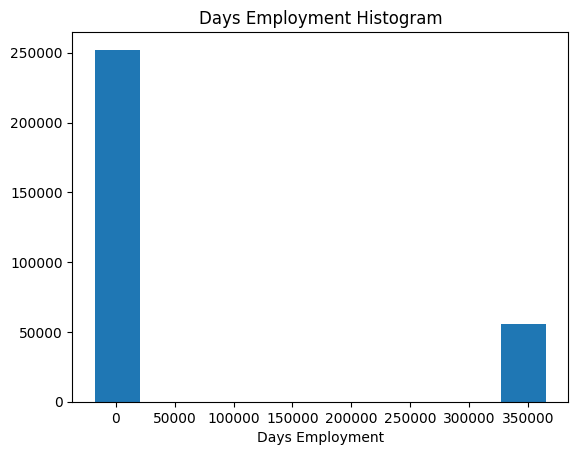

In [35]:
fig, ax = plt.subplots()

ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')
plt.show()

In [36]:
# Subset the extreme values and see if the target is different
anom = application_train[application_train['DAYS_EMPLOYED'] == 365243]
non_anom = application_train[application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


How to correct these outliers ? Since we're missing business information on this, the safest way to deal with it is to replace with NaN and proceed to an imputation before the predictive model. Here, these outliers have the same value. Is there a link between all these rows? We'll keep a track of this information by adding a variable indicating wether or not this value was normal or not.

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1687167807.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


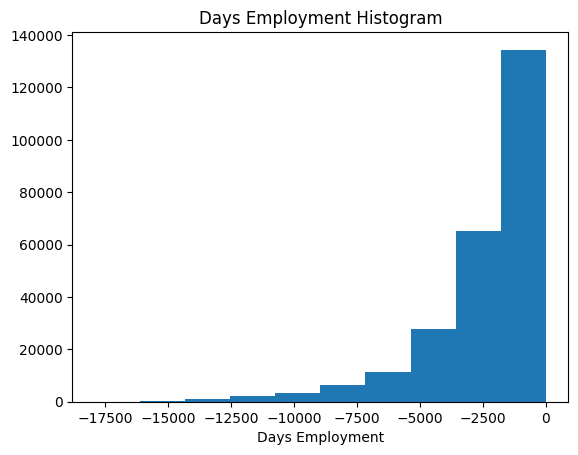

In [37]:
# Create an anomalous flag column
application_train['DAYS_EMPLOYED_ANOM'] = application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

fig, ax = plt.subplots()
ax.hist(application_train['DAYS_EMPLOYED'])
ax.set_title('Days Employment Histogram')
ax.set_xlabel('Days Employment')

plt.show()

In [38]:
application_train[quantitative_vars].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,252133.000000,...,307507.000000,307507.000000,307507.000000,307507.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,-2384.142254,...,0.008130,0.000595,0.000507,0.000335,0.006403,0.007000,0.034362,0.267388,0.265474,1.899950
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,4363.982424,2338.327666,...,0.089799,0.024388,0.022518,0.018299,0.083850,0.110758,0.204686,0.915994,0.794060,1.869286
min,100002.000000,0.00000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189146.500000,0.00000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-3175.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278203.000000,0.00000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1648.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367143.500000,0.00000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-767.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.00000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Apply changes to application_trest

In [39]:
application_test['DAYS_EMPLOYED_ANOM'] = application_test["DAYS_EMPLOYED"] == 365243
application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (application_test["DAYS_EMPLOYED_ANOM"].sum(), len(application_test)))

There are 9274 anomalies in the test data out of 48744 entries


/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1365247110.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)


## Correlations with target

In [40]:
correlations = application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043017
FLAG_DOCUMENT_3                                      0.044341
REG_CITY_NOT_LIVE_CITY                               0.044394
FLAG_EMP_PHONE                                       0.045984
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
REG_CITY_NOT_WORK_CITY                               0.050992
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER                                          0.054710
DAYS_LAST_PHONE_CHANGE                               0.055219
NAME_INCOME_TYPE_Working                             0.057483
REGION_RATING_CLIENT                                 0.058901
REGION_RATING_CLIENT_W_CITY                          0.060895
DAYS_EMPLOYED                                        0.074957
DAYS_BIRTH                                           0.078242
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### The age

The age seems to me the most correlated variable. It is expressed in days and is negative. For better understanding, let's take the absolute value.

In [41]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

np.float64(-0.07824216003619376)

The trend of repaying a loans grows with the client age. 

Let's understand the repartition of clients age in ur dataset

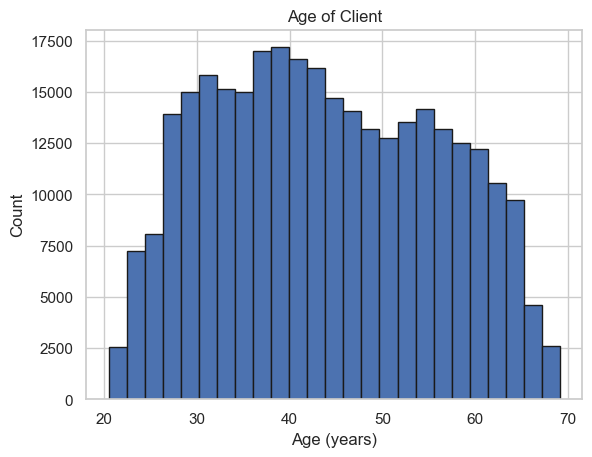

In [42]:
# set seaborn grid style
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots()

ax.hist(application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)

ax.set_title('Age of Client')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Count')

plt.show()

No outliers and ages are in a reasonable range.

Using KDE to visualie the effect of the age on the target.

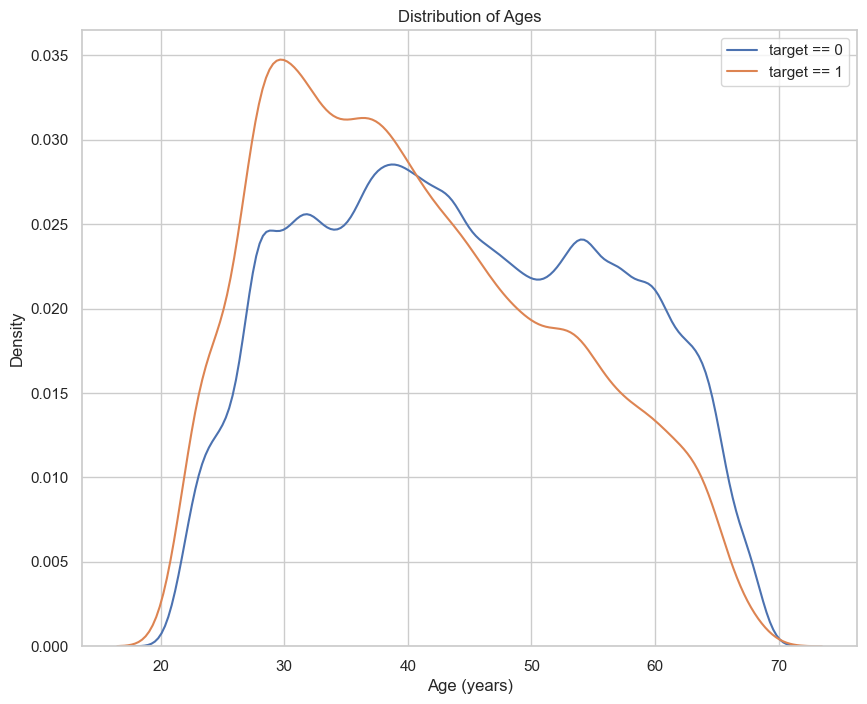

In [43]:
# Kernel density estimation
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Ages')

plt.show()

Even though the correlation coefficient is low, we notice that the curve is skewed toward the younger end of the range for target == 1.

Let's understand the the average failure to repay a loan by age brackets.

In [44]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Cut the age into bins of 5 years each
age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1512388715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1512388715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['DAYS_BIRTH'] / 365, bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [45]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_35581/1757995694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups  = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111442,10155.219690,27.822520
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089416,13707.908041,37.555912
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055316,20984.285455,57.491193
"(60.0, 65.0]",0.052737,22780.547460,62.412459


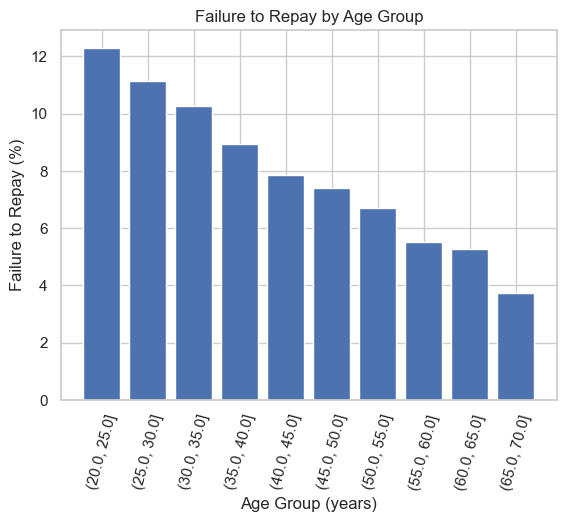

In [46]:
fig, ax = plt.subplots()

ax.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

ax.set_title('Failure to Repay by Age Group')
ax.set_xlabel('Age Group (years)')
ax.set_ylabel('Failure to Repay (%)')
# rotate x ticks
plt.xticks(rotation = 75)

plt.show()

We can clearly observe the trend that youngers are more likely to not repay their loan

### External ressources

External csources are the most negavely correlated to the target. What are those ?

In [47]:
# According to the documentation
application_description[application_description['Row'].isin(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])][["Row", "Description", "Special"]]

,Row,Description,Special
44,EXT_SOURCE_1,Normalized score from external data source,normalized
45,EXT_SOURCE_2,Normalized score from external data source,normalized
46,EXT_SOURCE_3,Normalized score from external data source,normalized


Doesn't give much information. How do they play around the target and other correlated variable ?

Text(0.5, 1.0, 'Correlation Heatmap')

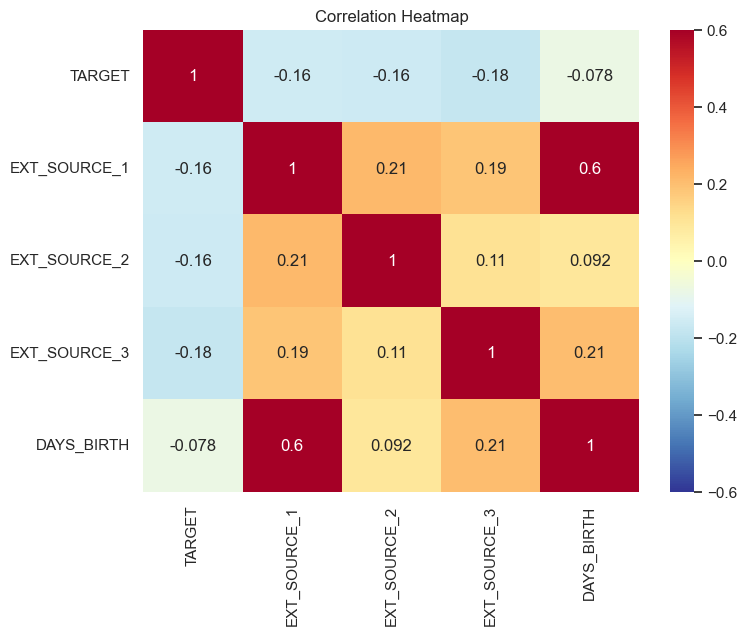

In [48]:
# get correlation of the EXT_SOURCE features with the target and plot them
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.6, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

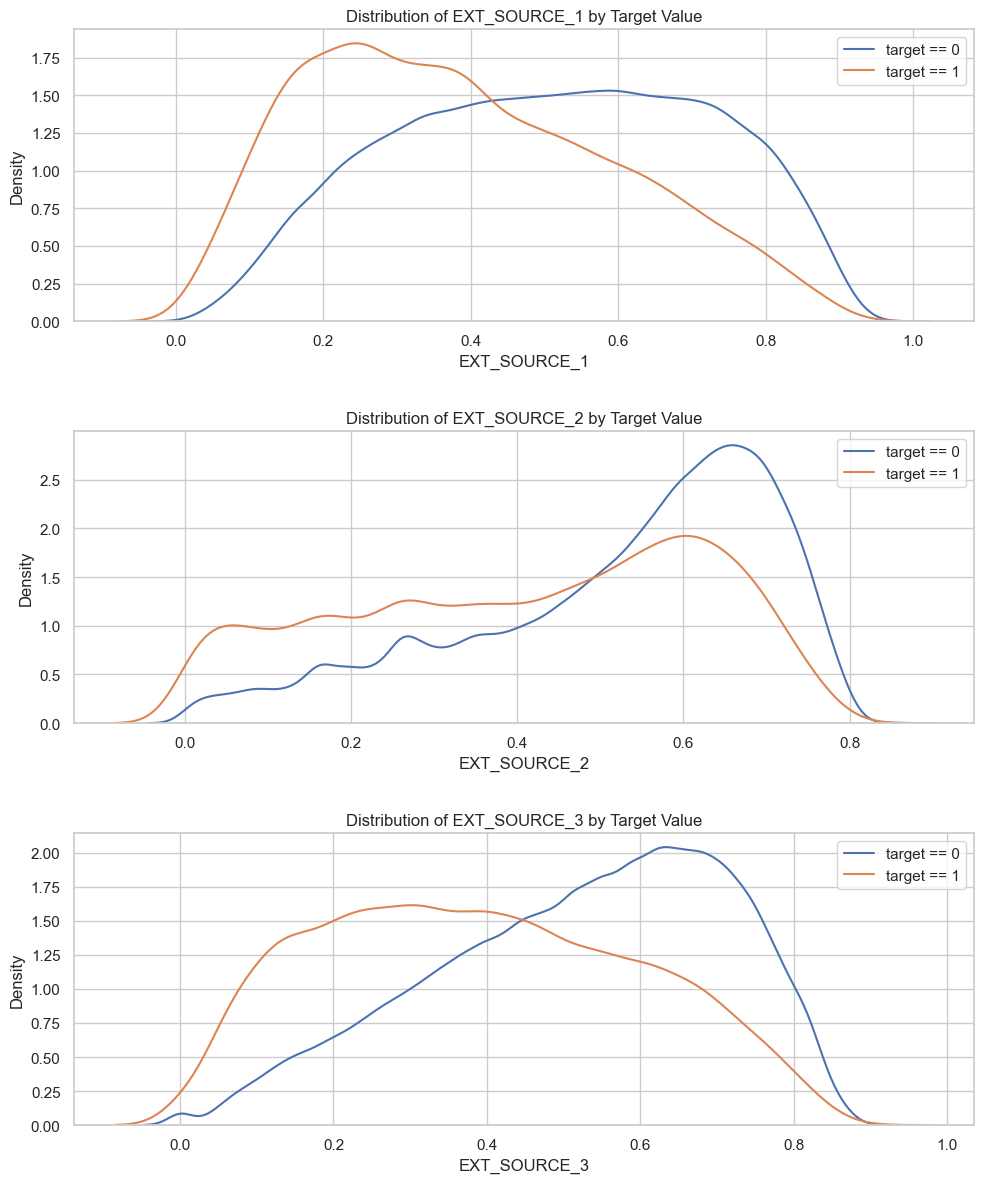

In [49]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()

plt.tight_layout(h_pad = 2.5)

# Features engineering

##  Simple new features 

In [50]:
app_train_domain = application_train.copy()
app_test_domain = application_test.copy()

# Ratio of credit amount compared to income
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
# Ratio of annuity amount compared to income
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
# Ratio of credit amount compared to annuity amount
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
# The ratio of days work in a life
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [51]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

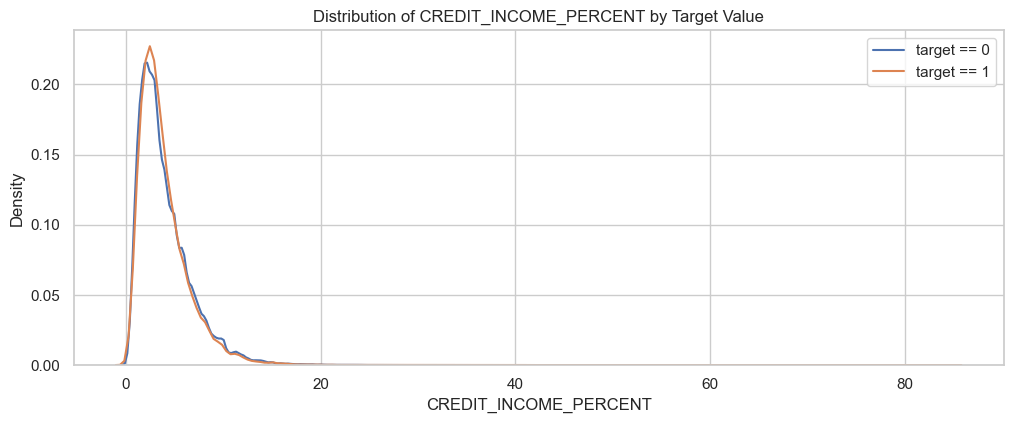

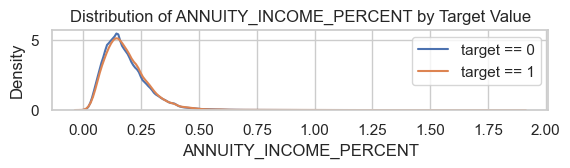

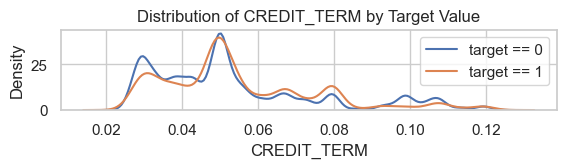

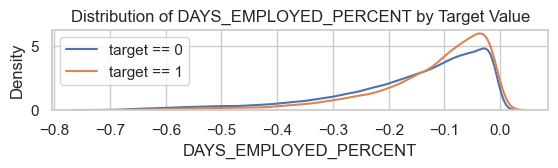

In [52]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')
    plt.legend()

    plt.show()

# Imputations and features scaling

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in application_train:
    train = application_train.drop(columns = ['TARGET'])
else:
    train = application_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = application_test.copy()

In [54]:
# Median imputation of missing values because this is a method which is less impacted by outliers

imputer = SimpleImputer(strategy="median")

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

In [55]:
# Values are often between 0 and 1
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [56]:
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (307507, 239)
Testing data shape:  (48744, 239)


In [57]:
import psutil

# Get the virtual memory details
memory_info = psutil.virtual_memory()

# Print the available memory
print(f"Total Memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"Available Memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"Used Memory: {memory_info.used / (1024 ** 3):.2f} GB")
print(f"Memory Percentage: {memory_info.percent}%")

Total Memory: 8.00 GB
Available Memory: 1.79 GB
Used Memory: 2.53 GB
Memory Percentage: 77.6%
